In [1]:
from collections import Counter
import pprint
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tqdm import tqdm

In [2]:
f = open(f"./s-by-s_test_processed.txt", "r")
sentences = f.readlines()
f.close()

sentences = [sentence.rstrip() for sentence in sentences if len(sentence) > 2]
print(len(sentences))
sentences[48]

200189


'The_AT0 Security_NN1 Service_NN1 is_VBZ part_NN1 of_PRF the_AT0 Defence_NN1 Forces_NN2 of_PRF the_AT0 country_NN1'

In [3]:
# Reference index dictionaries for conversion between tag and its index

index_to_tags = np.load("index_to_tag.npy").item()
tags_to_index = np.load("tag_to_index.npy").item()
print(index_to_tags)

{0: 'NN1', 1: 'AT0', 2: 'PRP', 3: 'AJ0', 4: 'NN2', 5: 'NP0', 6: 'AV0', 7: 'PNP', 8: 'CJC', 9: 'PRF', 10: 'VVI', 11: 'DT0', 12: 'VVN', 13: 'VVD', 14: 'CRD', 15: 'TO0', 16: 'DPS', 17: 'VM0', 18: 'VBD', 19: 'VVG', 20: 'CJS', 21: 'VBZ', 22: 'VVB', 23: 'VVZ', 24: 'POS', 25: 'XX0', 26: 'CJT', 27: 'AVP', 28: 'VBI', 29: 'DTQ', 30: 'NN0', 31: 'VBB', 32: 'NN1-VVB', 33: 'AJ0-NN1', 34: 'VHD', 35: 'ORD', 36: 'NP0-NN1', 37: 'VHZ', 38: 'VHB', 39: 'VBN', 40: 'PNI', 41: 'PNQ', 42: 'NN1-AJ0', 43: 'PRP-AVP', 44: 'EX0', 45: 'VVN-VVD', 46: 'AJC', 47: 'AVQ', 48: 'VVB-NN1', 49: 'VVD-VVN', 50: 'VHI', 51: 'NN1-NP0', 52: 'VVG-AJ0', 53: 'PNX', 54: 'UNC', 55: 'AJS', 56: 'NN2-VVZ', 57: 'VDB', 58: 'VDD', 59: 'VVG-NN1', 60: 'VVN-AJ0', 61: 'VBG', 62: 'AVP-PRP', 63: 'CJT-DT0', 64: 'AV0-AJ0', 65: 'NN1-VVG', 66: 'AJ0-AV0', 67: 'ITJ', 68: 'VVZ-NN2', 69: 'VDI', 70: 'PRP-CJS', 71: 'AJ0-VVG', 72: 'CJS-AVQ', 73: 'ZZ0', 74: 'VDZ', 75: 'CJS-PRP', 76: 'AJ0-VVN', 77: 'DT0-CJT', 78: 'VHG', 79: 'AJ0-VVD', 80: 'VDN', 81: 'VHN', 82:

In [4]:
# preparing test data

# samples_as_they_come = True # use test samples as they come during testing (can be repeated)

# if samples_as_they_come:
#     test_words = [word_tag_pair.split('_')[0] for word_tag_pair in test_word_tag_pairs]
#     unique_test_words = [word_tag_pair.split('_')[0] for word_tag_pair in word_tag_pairs]
#     print(len(unique_test_words))
#     print(len(test_words))
#     gt_tags = [tags_to_index[word_tag_pair.split('_')[1]] for word_tag_pair in test_word_tag_pairs]
# else:
#     test_words = [word_tag_pair.split('_')[0] for word_tag_pair in word_tag_pairs]
#     print(len(test_words))
#     gt_tags = [tags_to_index[word_tag_pair.split('_')[1]] for word_tag_pair in word_tag_pairs]

# test_words[20]

In [5]:
# load the model

em_probs = np.load("word_given_tag.npy").item()
tr_probs = np.load("Trans_Matrix.npy")

print(em_probs["VVI"]["make"])
print(em_probs["VVI"]["encourage"])

0.02532414624612037
0.001987500412100204


In [6]:
# emprob_ofthisword_witheach_tag = {}
# for word in tqdm(unique_test_words):
#     if word not in emprob_ofthisword_witheach_tag:
#         emprob_ofthisword_witheach_tag[word] = []
    
#     for idx in range(len(index_to_tags)):
#         emprob_ofallwords_forthis_tag = em_probs.get(index_to_tags[0])
#         try:
#             emprob_word_tag = [emprob[1] for emprob in emprob_ofallwords_forthis_tag if emprob[0]==f"{test_words[idx]}_{index_to_tags[idx]}"][0]
#         except:
#             emprob_word_tag = 0
        
#         emprob_ofthisword_witheach_tag[word] += [emprob_word_tag]
        
# print(emprob_ofthisword_witheach_tag["make"][8])

In [15]:
# correct_pred = 0
# total_pred = 0

gt_tags = []
pred_tags = []

for sentence in tqdm(sentences):
    prev_tag = "start"
    
    for word_tag_pair_idx in range(len(sentence.split(" "))):
        word_tag_pair = sentence.split(" ")[word_tag_pair_idx]
        if len(word_tag_pair.strip()) != 0:
            #print(word_tag_pair)
            word = word_tag_pair.split("_")[0]
            gt_tag = tags_to_index[word_tag_pair.split("_")[1]]
    
            possible_tags = []
            for idx in range(len(index_to_tags)):
                try:
                    emprob_for_this_word_tag = em_probs[index_to_tags[idx]][word]
                except:
                    emprob_for_this_word_tag = 0

                tr_prob = tr_probs[tags_to_index[prev_tag], idx]

                possible_tags.append(emprob_for_this_word_tag*tr_prob)

            possible_tags = np.array(possible_tags)
            if np.max(possible_tags) == 0:
                predicted_tag = index_to_tags[np.argmax(tr_probs[tags_to_index[prev_tag]])]
            else:
                predicted_tag = index_to_tags[np.argmax(possible_tags)]
            
#             total_pred += 1
#             if (tags_to_index[predicted_tag] == gt_tag):
#                 correct_pred += 1
            gt_tags.append(gt_tag)
            pred_tags.append(tags_to_index[predicted_tag])

            prev_tag = predicted_tag
            #print(f"{predicted_tag}, {index_to_tags[gt_tag]}")

100%|█████████████████████████████████████████████████████████████████████████| 199464/199464 [13:58<00:00, 237.90it/s]


In [17]:
#accuracy calculation

count_cp = 0
for index in range(len(gt_tags)):
    if gt_tags[index] == pred_tags[index]:
        # correct prediction
        count_cp += 1

accuracy = count_cp/len(gt_tags)
print(f"Accuracy = {accuracy*100}")

Accuracy = 90.86099737625035


In [18]:
new_sentence = "The Security Service is part of the Defence Forces of the country"

for word_tag_pair_idx in range(len(new_sentence.split(" "))):
        word_tag_pair = new_sentence.split(" ")[word_tag_pair_idx]
        word = word_tag_pair.split("_")[0]

        possible_tags = []
        for idx in range(len(index_to_tags)):
            try:
                emprob_for_this_word_tag = em_probs[index_to_tags[idx]][word]
            except:
                emprob_for_this_word_tag = 0

            tr_prob = tr_probs[tags_to_index[prev_tag], idx]

            possible_tags.append(emprob_for_this_word_tag*tr_prob)

        possible_tags = np.array(possible_tags)
        if np.max(possible_tags) == 0:
            predicted_tag = "UNC"
        else:
            predicted_tag = index_to_tags[np.argmax(possible_tags)]

        print(f"{word}: {predicted_tag}")
        prev_tag = predicted_tag

The: AT0
Security: NN1
Service: NN1
is: VBZ
part: NN1
of: PRF
the: AT0
Defence: NN1
Forces: NN2
of: PRF
the: AT0
country: NN1


In [20]:
# confusion matrix creation

cm = confusion_matrix(gt_tags, pred_tags)
np.savetxt("hmm_confusion_matrix.txt", cm, fmt="%d", delimiter="\t")
print(cm)
print(cm[20,20])

[[502165   1952   1232 ...      0      0      0]
 [    20 337121      0 ...      0      0      0]
 [   103     10 241585 ...      0      0      0]
 ...
 [    11     10      4 ...     27      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]]
38489


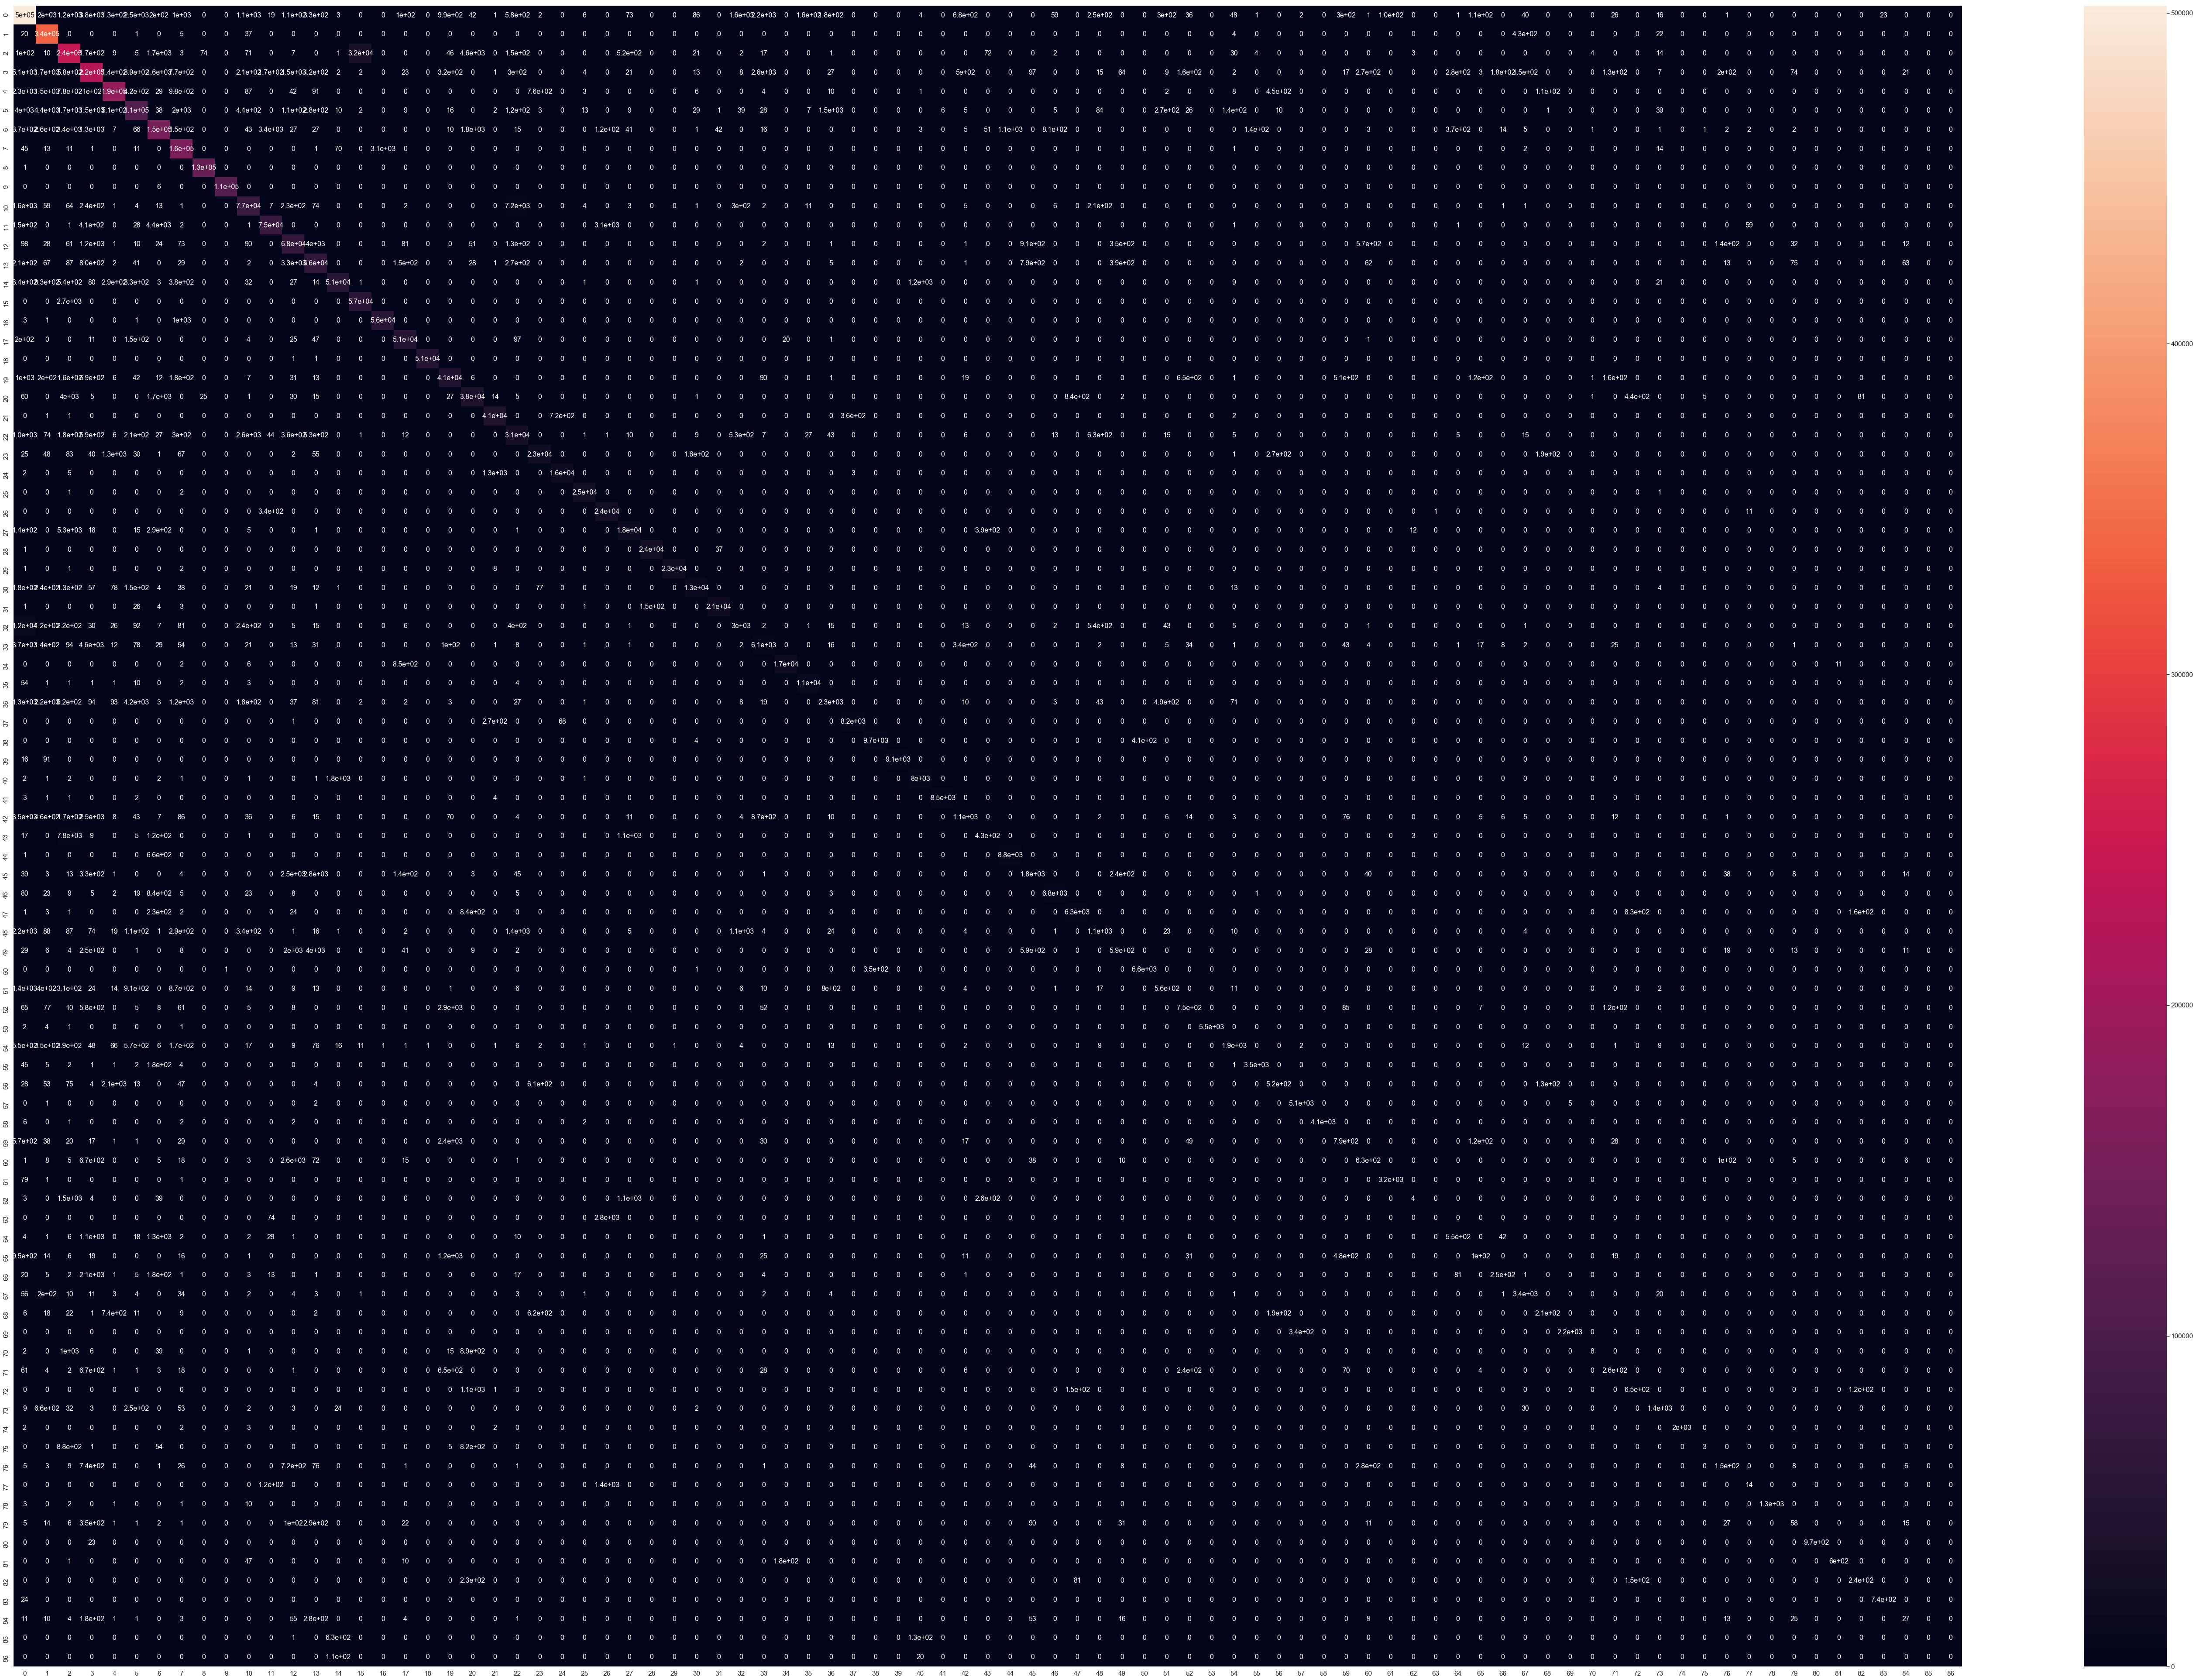

In [21]:
# Plotting the confusion matrix
plt.figure(figsize = (100,70))
sn.set(font_scale=1.4)#for label size
sn.heatmap(cm, annot=True,annot_kws={"size": 16})# font size